In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os
os.chdir("../../")
from ReusableCode.bv_vis import biasVarianceCompFrame, plotBV
os.chdir("./MedicalInsuranceCost/notebook/")

import warnings

# Load Data and EDA

In [6]:
df = pd.read_csv('.././data/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Column sex has 2 unique values


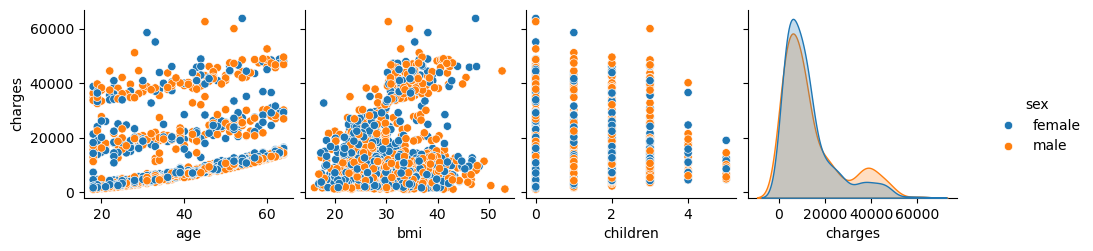

Column smoker has 2 unique values


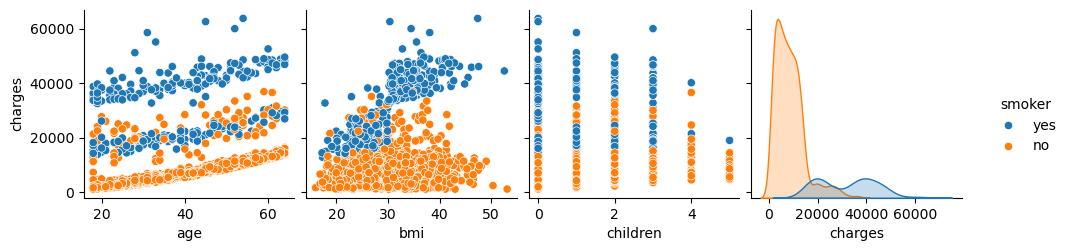

Column region has 4 unique values


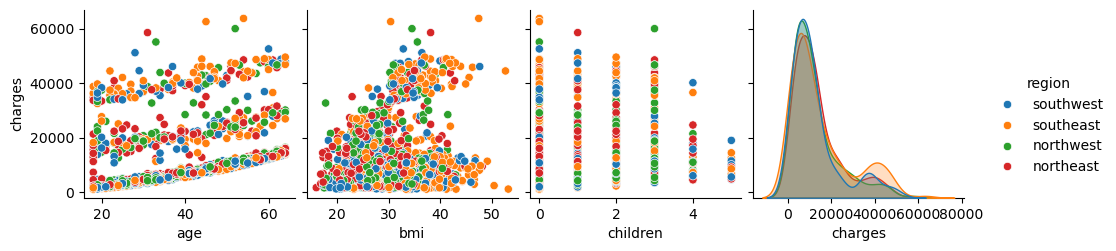

In [7]:
warnings.filterwarnings("ignore")
is_cat_column, is_num_column = [],[]
for c in df.columns:
    if df[c].dtype==object:
        print(f'Column {c} has {len(df[c].unique())} unique values')
        sns.pairplot(data = df, y_vars = 'charges',hue = c)
        plt.show()
        is_cat_column.append(c)
    else:
        is_num_column.append(c)

## Correllation Matrix

               age       bmi  children   charges
age       1.000000  0.109272  0.042469  0.299008
bmi       0.109272  1.000000  0.012759  0.198341
children  0.042469  0.012759  1.000000  0.067998
charges   0.299008  0.198341  0.067998  1.000000


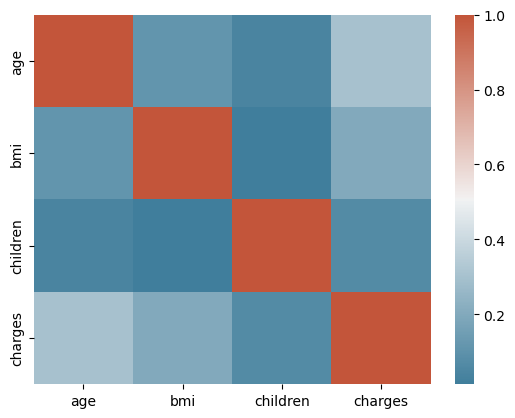

In [8]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df[is_num_column].corr(), cmap = cmap)

print(df[is_num_column].corr())

This is a pretty weak correlation matrix. The strongest predictor of ```charges``` is ```age``` but it is only $\approx .3$.

## Looking at BMI

Looking at the plot above, the ```bmi``` variable seems to have a sharp change at the value of 30.

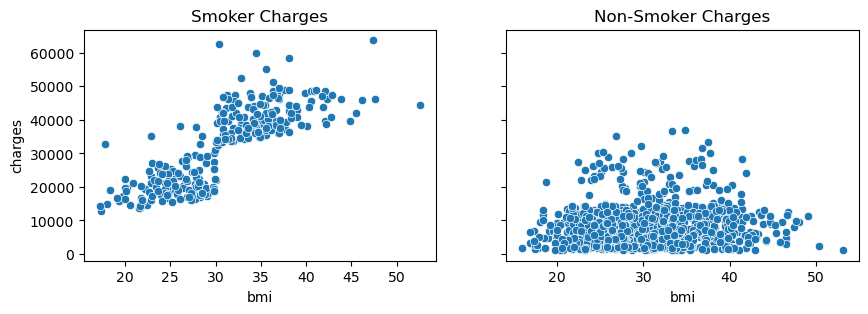

In [9]:
fig, ax = plt.subplots(1,2,figsize = (10,3),sharey = True)
sns.scatterplot(data = df[df.smoker=='yes'],x = 'bmi',y='charges',ax = ax[0])
sns.scatterplot(data = df[df.smoker=='no'],x = 'bmi',y='charges',ax = ax[1])
ax[0].set_title('Smoker Charges')
ax[1].set_title( 'Non-Smoker Charges')

plt.show()

Later, we will add another feature that captures this change.

# Analysis

## Split Data

In [10]:
## Manually create dummy variables
df = pd.read_csv('../data/insurance.csv')
df.sex = df.sex.apply(lambda x: 1*(x=='male'))
df.smoker = df.smoker.apply(lambda x: 1*(x=='yes'))
df['north_east'] = df.region.apply(lambda x: 1*(x =='northeast'))
df['north_west'] = df.region.apply(lambda x: 1*(x =='northwest'))
df['south_west'] = df.region.apply(lambda x: 1*(x =='southwest'))
df.drop(columns = ['region'],inplace = True)


## Reorder columns
cols = list(df.columns)
cols.append(cols.pop(5))
df = df[cols]
df.head()

## TrainTestSplit
from sklearn.model_selection import train_test_split
random_state = 42
df_train, df_test = train_test_split(df, test_size = .2, shuffle = True, random_state=random_state)
X_train = df_train[cols[:-1]].to_numpy()
X_test = df_test[cols[:-1]].to_numpy()
y_train = df_train[cols[-1]].to_numpy()
y_test = df_test[cols[-1]].to_numpy()

## Grid

from sklearn.model_selection import RepeatedKFold,GridSearchCV

n_repeats = 3
n_folds = 10
cv_trials = n_repeats*n_folds
cv = RepeatedKFold(n_repeats = n_repeats, n_splits = n_folds)

## Base Model (Linear Regression)

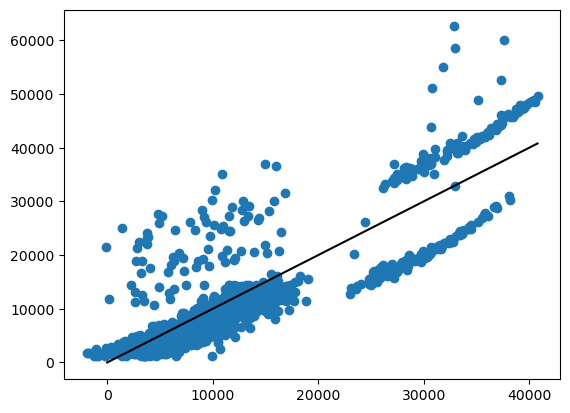

Base R2 is 0.742
Base RMSE is 6105.545


In [11]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred = lm.predict(X_train)
plt.scatter(y_pred,y_train)

plt.plot([0,max(y_pred)],[0,max(y_pred)],color = 'k')
plt.show()

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

RMSE = lambda x,y: MSE(x,y)**(1/2)

base_RMSE = RMSE(y_pred,y_train)
train_var = np.var(y_train)

base_r2 = r2_score(y_train,y_pred)
print(f"Base R2 is {base_r2:.3f}")
print(f"Base RMSE is {base_RMSE:.3f}")

## Load All Models

In [12]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

## Polynomial Features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer

## Pipeline
from sklearn.pipeline import Pipeline

## NN:
from sklearn.neural_network import MLPRegressor

In [13]:
# Standard Estimators
simple_estimators = {
    'lin_reg':LinearRegression(),
    'ridge':Ridge(),
    'lasso':Lasso(),
    'knn':KNeighborsRegressor(),
    'tree':DecisionTreeRegressor(random_state=random_state),
    'rf':RandomForestRegressor(random_state = random_state),
    'gb_reg':GradientBoostingRegressor(random_state=random_state),
    'mlp':MLPRegressor(random_state=random_state)
}

# Pipelines

## PolynomialTransformer
poly_features = [0,2,3]
pass_features = [j for j in range(X_train.shape[1]) if j not in poly_features]
poly = ColumnTransformer(
    transformers = [
        ('poly',PolynomialFeatures(include_bias=False),poly_features),
        ('pass','passthrough',pass_features)
    ]
)


pipelines = {
    'lin_reg_pipe':
        Pipeline(
            [
                ('pre', poly),
                ('model',LinearRegression())
            ]
        ),
    'lasso_pipe':
        Pipeline(
            [
                ('pre', poly),
                ('model',Lasso())
            ]
        ),
    'ridge_pipe':
        Pipeline(
            [
                ('pre', poly),
                ('model',Ridge())
            ]
        )
    
}

# Metrics
metrics = ['neg_root_mean_squared_error','neg_mean_absolute_error']


# Parameter Grids
max_degree = 7

poly_grid = {'pre__poly__degree':list(range(1,max_degree+1))}

regularization_range = [0.1,.2,.5,1,2,5,10]
ridge_lasso_params = {'alpha':regularization_range}
ridge_lasso_params_poly = {'model__alpha':regularization_range}
dt_params = {
    'splitter':['random','best'],
    'max_depth':list(range(2,21))
}

K_max = 10
knn_params = {
    'n_neighbors':list(range(1,K_max+1)),
    'weights':['uniform','distance']
}

max_depth = 7
min_depth = 2
rf_params = {
    'max_depth':list(range(min_depth,max_depth+1)),
    'n_estimators':[25,50,75,100]
}

gb_params = {
    'max_depth':list(range(min_depth,max_depth+1)),
    'n_estimators':[25,50,75,100]
}


mlp_params = {
'hidden_layer_sizes' : [(128,256, 16, 4,), (128, 16, 4,), (64,64, 32, 8,)],
'activation' : ['relu','logistic']
}

param_grids = {
    'lin_reg':{},
    'ridge':ridge_lasso_params,
    'lasso':ridge_lasso_params,
    'knn':knn_params,
    'tree':dt_params,
    'rf':rf_params,
    'gb_reg':gb_params,
    'lin_reg_pipe':poly_grid,
    'lasso_pipe':poly_grid|ridge_lasso_params_poly,
    'ridge_pipe':poly_grid|ridge_lasso_params_poly,
    'mlp':mlp_params
}

# Rename Parameters

param_renames = {
    'ridge':{'Regularization Parameter':'param_alpha'},
    'lasso':{'Regularization Parameter':'param_alpha'},
    'knn':{'Neighbors':'param_n_neighbors','Weight':'param_weights'},
    'tree':{'Depth':'param_max_depth','Splitter':'param_splitter'},
    'rf':{'Depth':'param_max_depth','Estimators':'param_n_estimators'},
    'gb_reg':{'Depth':'param_max_depth','Estimators':'param_n_estimators'},
    'mlp'
    'lin_reg_pipe':{'Degree':'param_pre__poly__degree'},
    'lasso_pipe':{'Degree':'param_pre__poly__degree','Regularization Parameter':'param_model__alpha'},
    'ridge_pipe':{'Degree':'param_pre__poly__degree','Regularization Parameter':'param_model__alpha'},
    'mlp':{'Hidden Layers':'hidden_layer_sizes', 'Activation':'activation'}
}

complexity_params = {
    'ridge':'Regularization Parameter',
    'lasso':'Regularization Parameter',
    'knn':'Neighbors',
    'tree':'Depth',
    'rf':'Depth',
    'gb_reg':'Depth',
    'lin_reg_pipe':'Degree',
    'lasso_pipe':'Degree',
    'ridge_pipe':'Degree'
}

hues = {
    'ridge':[],
    'lasso':[],
    'knn':['Weight'],
    'tree':['Splitter'],
    'rf':['Estimators'],
    'gb_reg':['Estimators'],
    'lin_reg_pipe':[],
    'lasso_pipe':['Regularization Parameter'],
    'ridge_pipe':['Regularization Parameter']
}

titles = {
    'ridge':'Ridge Regression',
    'lasso':"Lasso Regression",
    'knn':"k-Nearest Neighbors",
    'tree':"Decision Tree",
    'rf':'Random Forest Regressor',
    'gb_reg':"Gradient Boosing Regressor",
    'lin_reg_pipe':"Linear Regression with Polynomial Features",
    'lasso_pipe':"Lasso with Polynomial Features",
    'ridge_pipe':"Ridge with Polynomial Features"
}

In [14]:
model_names = list((simple_estimators|pipelines).keys())
all_models = simple_estimators|pipelines
grid_results = {}
best_esimators = {}
best_scores = {}
best_params = {}

for model in model_names:
    estimator = all_models[model]
    param = param_grids[model]
    grid = GridSearchCV(
        estimator = estimator,
        param_grid=param,
        scoring = metrics,
        return_train_score=True,
        cv = cv,
        refit = metrics[0]
    )
    grid.fit(X_train,y_train)
    best_esimators[model] = grid.best_estimator_
    grid_results[model] = pd.DataFrame(grid.cv_results_)
    best_scores[model] = grid.best_score_
    best_params[model] = grid.best_params_


In [15]:
metric_dict = {'RMSE':'neg_root_mean_squared_error', 'MAE':'neg_mean_absolute_error'}

reformatted_grid = {}
for model in model_names:
    if model=='lin_reg':
        continue
    reformatted = biasVarianceCompFrame(
        df = grid_results[model],
        metrics = metric_dict,
        cv_trials = cv_trials,
        parameters = param_renames[model],
        reverseMetricSign=True
    )
    reformatted_grid[model] = reformatted

KeyError: 'hidden_layer_sizes'

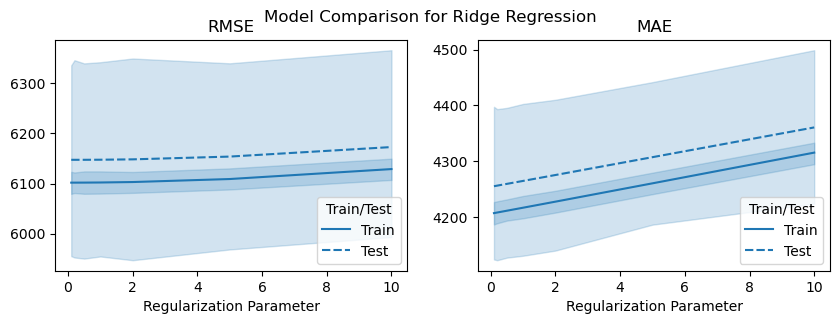

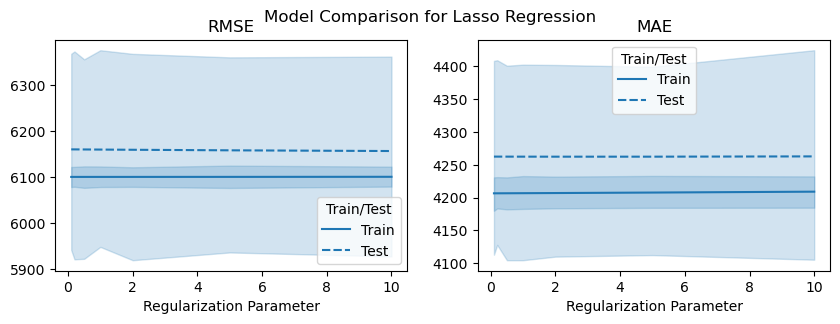

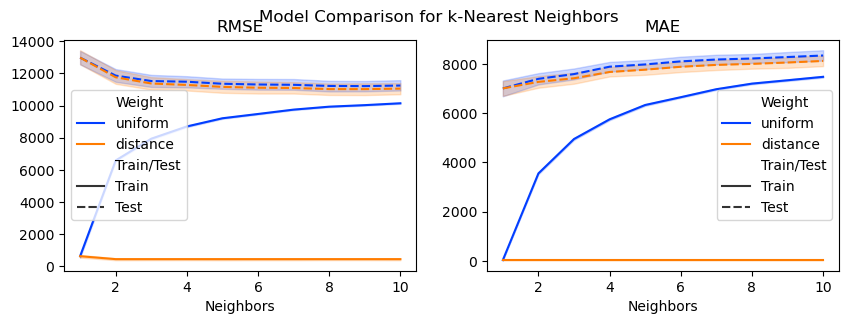

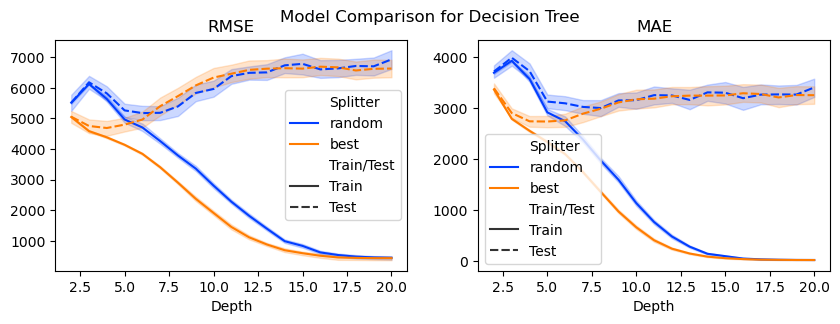

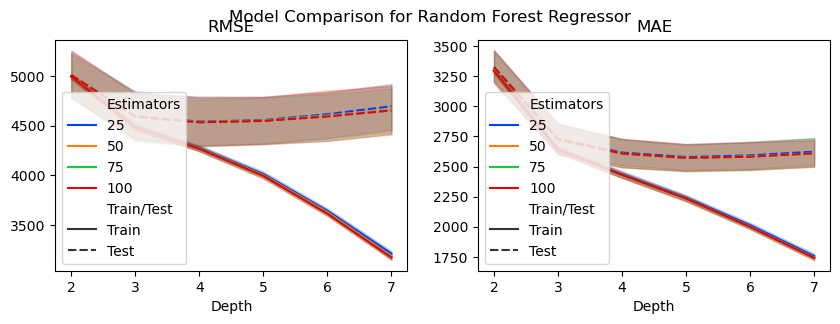

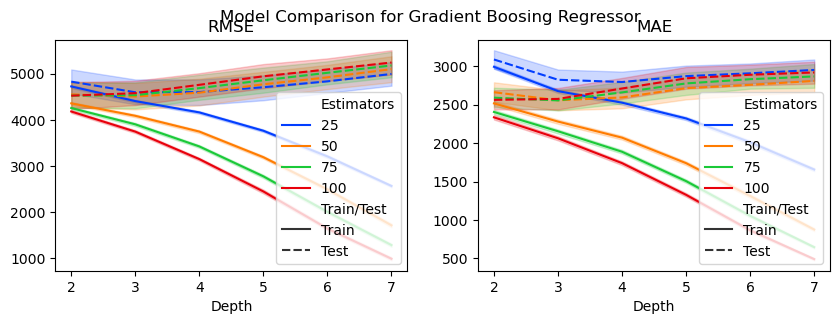

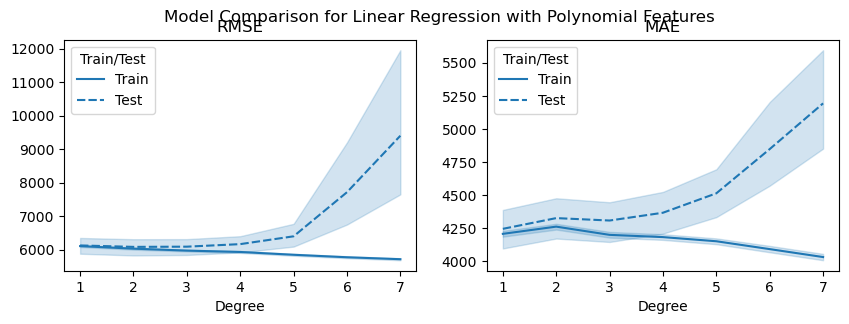

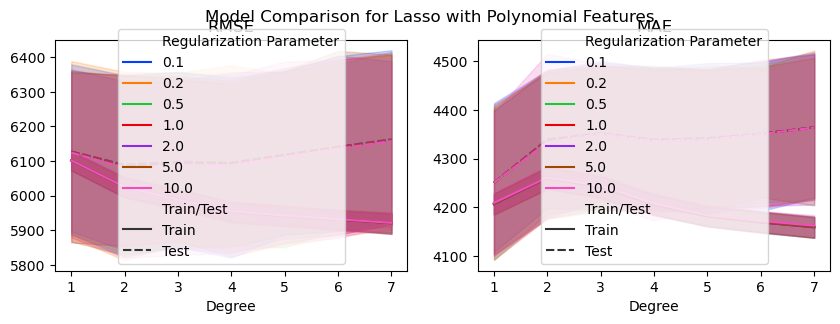

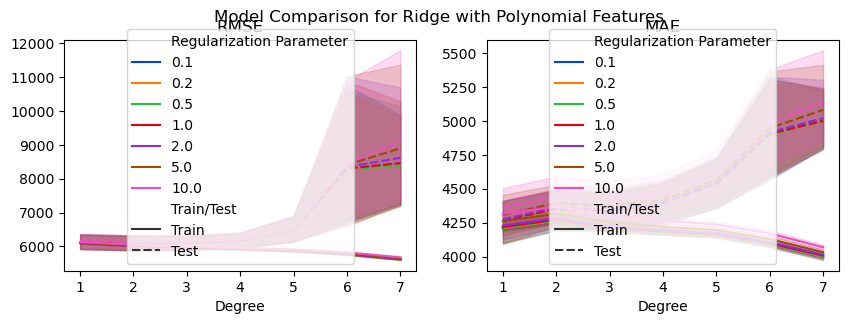

In [ ]:
metric_names = list(metric_dict.keys())
style = 'Train/Test'
subplotSize = (5,3)
for model in model_names:
    if model=='lin_reg' or model=='mlp':
        continue
    reform_df = reformatted_grid[model]
    title = 'Model Comparison for '+titles[model]
    complexity = complexity_params[model]
    hue = hues[model]
    plotBV(df = reform_df,
           metrics=metric_names,
           title = title,
           hues = hue,
           complexity_param = complexity,
           subplotSize = subplotSize,
           style = style
           )

In [ ]:
best_cv_score = float('inf')
for model in model_names:
    cv_score = -best_scores[model]
    if cv_score < best_cv_score:
        best_cv_score = cv_score
        best_model = best_esimators[model]
        best_param_set = best_params[model]

print(f'The best model is \n\t{best_model}.'
        +f'\nThe parameters are \n\t{best_param_set}.'
        + f'\nThe best cv score is \n\t{best_cv_score:.4f}.'
        + f'\nThe base cv score is \n\t{-best_scores['lin_reg']:.4f}.'
    )

The best model is 
	GradientBoostingRegressor(n_estimators=50, random_state=42).
The parameters are 
	{'max_depth': 3, 'n_estimators': 50}.
The best cv score is 
	4502.5576.
The base cv score is 
	6131.4419.


## Generate an additional feature


As described above, we will include a new feature capturing the apparent spike in charges for smokers with a BMI over 30.

For this, we will look at the **subset** of the data points $(x_i,y_i)$ consisting of the smokers and minimize
\begin{align*}
\sum_{i=1}^n\left( y_i - \alpha \sigma\left( \beta(x_i-\gamma)\right)-\delta\right)^2
\end{align*}
where $\alpha,\beta,\gamma,\delta$ are parameters we optimize.

For this we will use PyTorch.

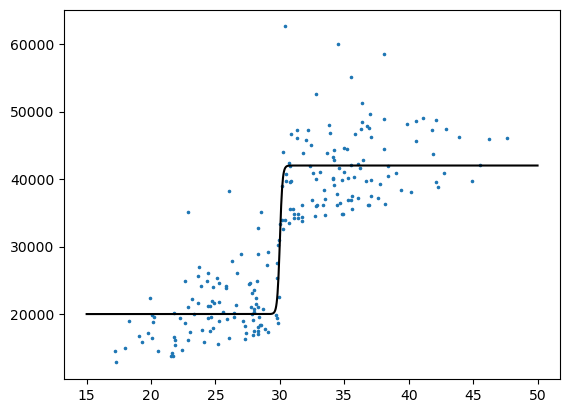

In [ ]:
x_smoker = df_train[df_train['smoker'] ==1].bmi.to_numpy().reshape(-1,1)
y_smoker = df_train[df_train['smoker'] ==1].charges.to_numpy().reshape(-1,1)
plt.scatter(x_smoker, y_smoker, s = 2.5)
alpha = 22000
delta = 20000
beta = 10
gamma = 30
f = lambda x:alpha/(1+np.exp(-beta*(x-gamma)))+delta
plt.plot(np.linspace(15,50,1000), f(np.linspace(15,50,1000)), 'k')

In [ ]:
import torch.nn as nn
import torch
from tqdm import trange



class WarmStartRegression(nn.Module):
    def __init__(self,alpha,beta,delta,gamma):
        super().__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha,dtype = torch.float32))
        self.beta = nn.Parameter(torch.tensor(beta,dtype = torch.float32))
        self.gamma = nn.Parameter(torch.tensor(-gamma,dtype = torch.float32))
        self.delta = nn.Parameter(torch.tensor(delta,dtype = torch.float32))
        self.act = nn.Sigmoid()

    def forward(self,x):
        x = torch.add(x,self.gamma)
        x = torch.mul(x,self.beta)
        x = self.act(x)
        x = torch.mul(x,self.alpha)
        x = torch.add(x,self.delta)

        return x

warm_alt_log_r = WarmStartRegression(alpha,beta,delta,gamma)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adagrad(warm_alt_log_r.parameters(), lr = .05)

x_smoker = torch.tensor(x_smoker,dtype = torch.float32)
y_smoker = torch.tensor(y_smoker, dtype = torch.float32)

n_epochs = 10000

for epoch in trange(n_epochs):
    optimizer.zero_grad()
    y_pred = warm_alt_log_r(x_smoker)
    error = loss_fn(y_pred, y_smoker)
    error.backward()
    optimizer.step()
    if (epoch+1)%1000 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, RMSE Loss: {error.item()**(1/2):.4f}")

beta = warm_alt_log_r.beta.detach()
gamma = -warm_alt_log_r.gamma.detach()

f = lambda x : 1/(1+np.exp(-beta*(x-gamma)))

 13%|█▎        | 1322/10000 [00:00<00:03, 2196.05it/s]

Epoch 1000/10000, RMSE Loss: 5322.7072


 22%|██▏       | 2232/10000 [00:01<00:03, 2247.62it/s]

Epoch 2000/10000, RMSE Loss: 5322.5892


 34%|███▎      | 3372/10000 [00:01<00:02, 2264.96it/s]

Epoch 3000/10000, RMSE Loss: 5322.5182


 43%|████▎     | 4297/10000 [00:01<00:02, 2300.18it/s]

Epoch 4000/10000, RMSE Loss: 5322.5182


 52%|█████▏    | 5216/10000 [00:02<00:02, 1990.08it/s]

Epoch 5000/10000, RMSE Loss: 5322.5182


 63%|██████▎   | 6349/10000 [00:02<00:01, 2223.49it/s]

Epoch 6000/10000, RMSE Loss: 5322.5182


 73%|███████▎  | 7259/10000 [00:03<00:01, 2229.92it/s]

Epoch 7000/10000, RMSE Loss: 5322.5182


 84%|████████▍ | 8390/10000 [00:03<00:00, 2215.84it/s]

Epoch 8000/10000, RMSE Loss: 5322.5182


 93%|█████████▎| 9271/10000 [00:04<00:00, 2163.24it/s]

Epoch 9000/10000, RMSE Loss: 5322.5182


100%|██████████| 10000/10000 [00:04<00:00, 2199.56it/s]

Epoch 10000/10000, RMSE Loss: 5322.5182


In [ ]:
df_train['sigmoid'] = df_train.apply(lambda row:f(row.bmi) if row.smoker else 0, axis = 1)
df_test['sigmoid'] = df_test.apply(lambda row:f(row.bmi) if row.smoker else 0, axis = 1)
X_train_sigmoid = df_train[[c for c in df_train.columns if c!='charges']]

In [ ]:
grid_results_sigmoid = {}
best_esimators_sigmoid = {}
best_scores_sigmoid = {}
best_params_sigmoid = {}

for model in model_names:
    estimator = all_models[model]
    param = param_grids[model]
    grid = GridSearchCV(
        estimator = estimator,
        param_grid=param,
        scoring = metrics,
        return_train_score=True,
        cv = cv,
        refit = metrics[0]
    )
    grid.fit(X_train_sigmoid,y_train)
    best_esimators_sigmoid[model] = grid.best_estimator_
    grid_results_sigmoid[model] = pd.DataFrame(grid.cv_results_)
    best_scores_sigmoid[model] = grid.best_score_
    best_params_sigmoid[model] = grid.best_params_


In [ ]:
reformatted_grid_sigmoid = {}
for model in model_names:
    if model=='lin_reg':
        continue
    reformatted = biasVarianceCompFrame(
        df = grid_results_sigmoid[model],
        metrics = metric_dict,
        cv_trials = cv_trials,
        parameters = param_renames[model],
        reverseMetricSign=True
    )
    reformatted_grid_sigmoid[model] = reformatted

    

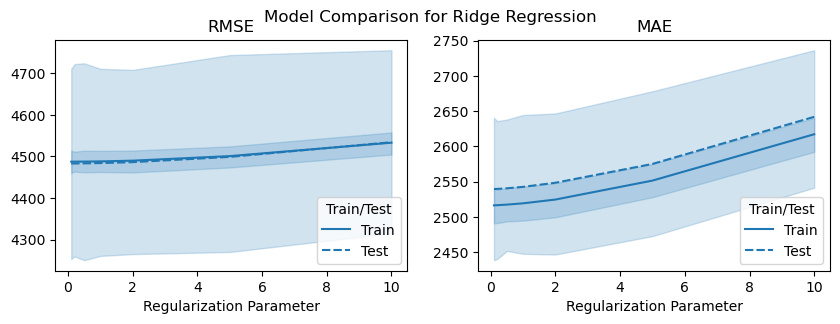

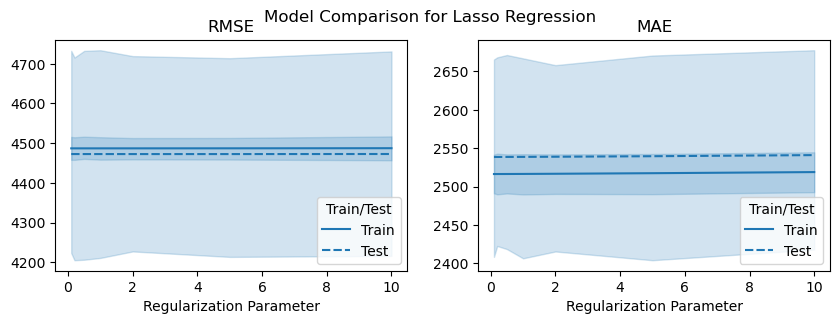

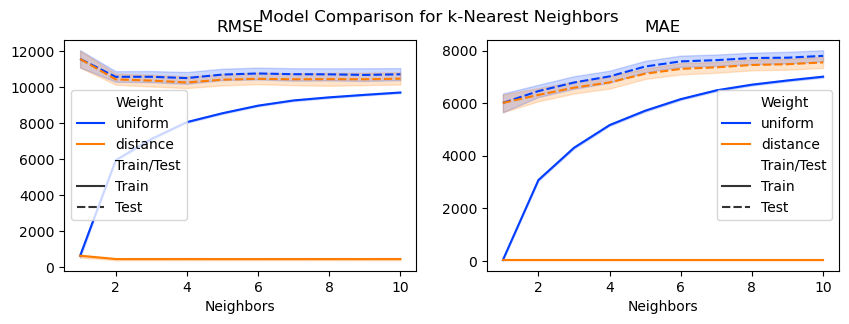

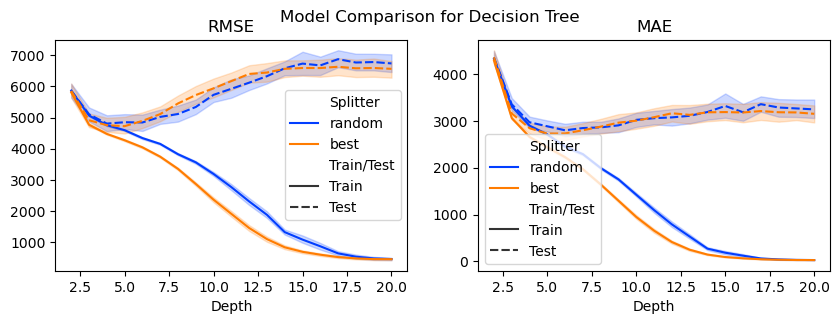

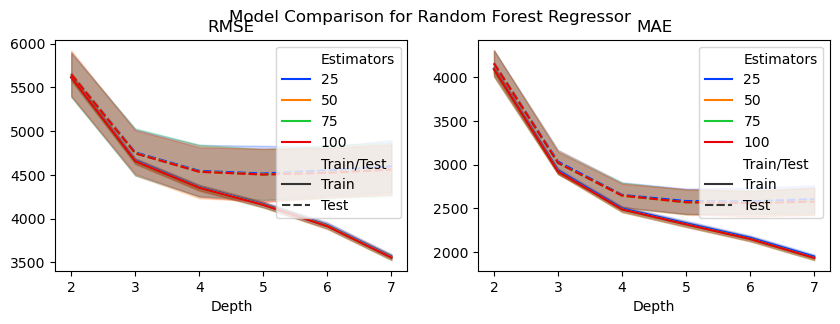

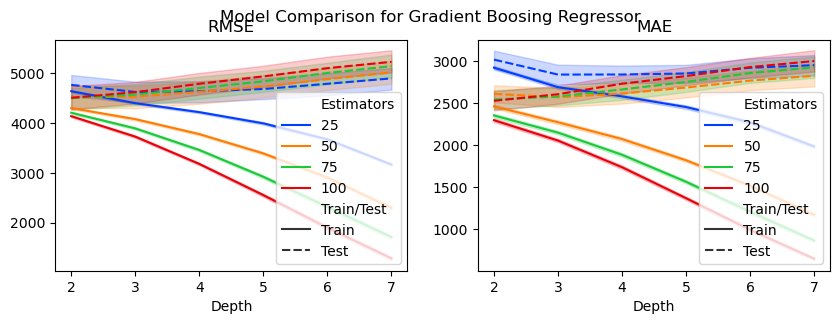

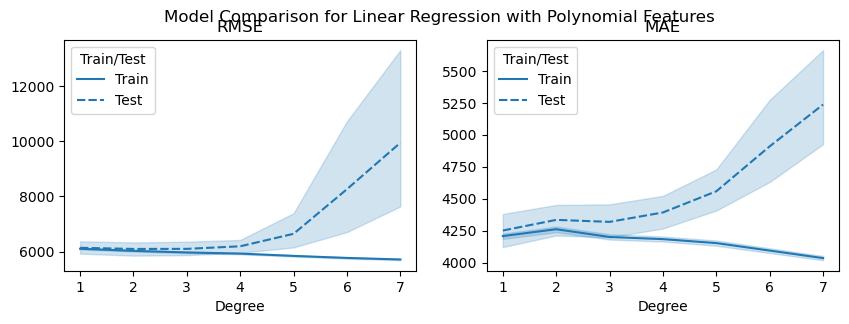

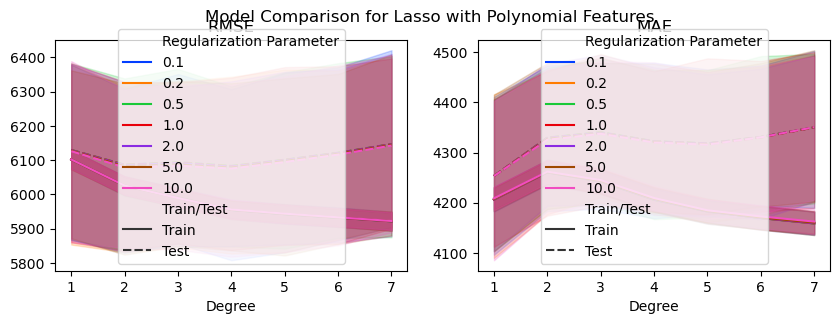

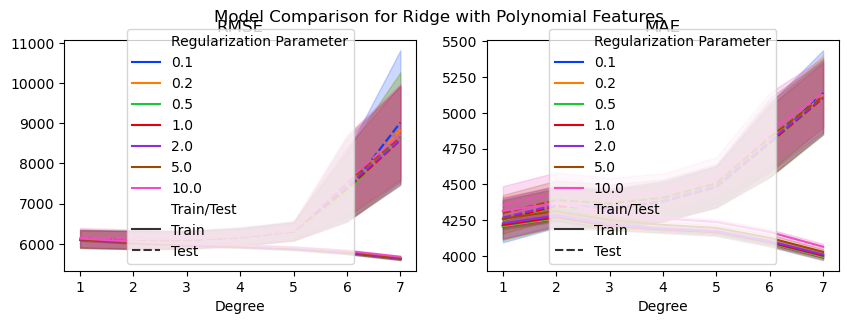

In [ ]:
metric_names = list(metric_dict.keys())
style = 'Train/Test'
subplotSize = (5,3)
for model in model_names:
    if model=='lin_reg':
        continue
    reform_df = reformatted_grid_sigmoid[model]
    title = 'Model Comparison for '+titles[model]
    complexity = complexity_params[model]
    hue = hues[model]
    plotBV(df = reform_df,
           metrics=metric_names,
           title = title,
           hues = hue,
           complexity_param = complexity,
           subplotSize = subplotSize,
           style = style
           )

In [ ]:
best_cv_score_sigmoid = float('inf')
for model in model_names:
    cv_score = -best_scores_sigmoid[model]
    if cv_score < best_cv_score:
        best_cv_score_sigmoid = cv_score
        best_model_sigmoid = best_esimators_sigmoid[model]
        best_param_set_sigmoid = best_params_sigmoid[model]

print(f'The best model is \n\t{best_model_sigmoid}.'
        +f'\nThe parameters are \n\t{best_param_set_sigmoid}.'
        + f'\nThe best cv score is \n\t{best_cv_score_sigmoid:.4f}.'
        + f'\nThe base cv score is \n\t{-best_scores_sigmoid['lin_reg']:.4f}.'
    )

The best model is 
	GradientBoostingRegressor(max_depth=2, n_estimators=75, random_state=42).
The parameters are 
	{'max_depth': 2, 'n_estimators': 75}.
The best cv score is 
	4502.0178.
The base cv score is 
	4491.5041.


## Neural nets